# Feature Importance Analysis for Telco Customer Churn

This notebook provides a comprehensive analysis of feature importance and influences on customer churn prediction using multiple methodologies including:

- Tree-based feature importance
- Permutation importance
- Correlation analysis
- SHAP (SHapley Additive exPlanations) values
- Statistical significance testing

## Objectives
1. Identify the most influential features for predicting customer churn
2. Compare different feature importance methods
3. Understand feature interactions and dependencies
4. Provide actionable insights for business decision-making

## 1. Import Required Libraries

In [21]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Try to import plotly, but continue without it if not available
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    plotly_available = True
    print("Plotly library loaded successfully")
except ImportError:
    plotly_available = False
    print("Plotly library not available. Using matplotlib/seaborn alternatives.")
    print("To install Plotly: pip install plotly")

plt.style.use('seaborn-v0_8')

# SHAP for interpretability - optional
try:
    import shap
    shap_available = True
    print("SHAP library loaded successfully")
except ImportError:
    shap_available = False
    print("SHAP library not available. Skipping SHAP analysis.")
    print("To install SHAP: pip install shap")

# Statistical libraries
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr, spearmanr

print("All available libraries imported successfully!")

Plotly library loaded successfully
SHAP library loaded successfully
All available libraries imported successfully!


## 2. Load and Prepare Dataset

In [2]:
# Set up paths
ROOT = Path("..").resolve()
DATA_PATH = ROOT / "data"
REPORTS_PATH = ROOT / "reports"

# Load the cleaned dataset
df = pd.read_csv(DATA_PATH / "telco__customer_churn_clean.csv")

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
df.head()

Dataset shape: (7043, 21)
Columns: ['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents', 'tenure', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges', 'churn']

First few rows:


,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Prepare features and target
# Convert target to binary (assuming 'Churn' or similar column exists)
target_col = 'churn'
"""
for col in ['churn', 'Churn', 'churn_flag']:
    if col in df.columns:
        target_col = col
        break

if target_col is None:
    # If no direct churn column, look for patterns
    churn_candidates = [col for col in df.columns if 'churn' in col.lower()]
    if churn_candidates:
        target_col = churn_candidates[0]
    else:
        print("Warning: No churn column found. Please specify the target column.")
        target_col = df.columns[-1]  # Use last column as fallback

print(f"Using '{target_col}' as target variable")
"""

# Convert target to binary if needed
if df[target_col].dtype == 'object':
    y = (df[target_col].str.upper() == 'YES').astype(int)
else:
    y = df[target_col].astype(int)

print(f"Churn distribution:\n{pd.Series(y).value_counts()}")
print(f"Churn rate: {y.mean():.2%}")

# Prepare features (exclude ID and target columns)
exclude_cols = [target_col, 'customerid', 'CustomerID', 'customer_id', 'ID', 'id']
X = df.drop(columns=[col for col in exclude_cols if col in df.columns], errors='ignore')

print(f"\nFeature matrix shape: {X.shape}")
print(f"Features: {list(X.columns)}")

# Basic data info
print(f"\nData types:")
print(X.dtypes.value_counts())
print(f"\nMissing values:")
print(X.isnull().sum().sum())

Churn distribution:
churn
0    5174
1    1869
Name: count, dtype: int64
Churn rate: 26.54%

Feature matrix shape: (7043, 19)
Features: ['gender', 'seniorcitizen', 'partner', 'dependents', 'tenure', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges']

Data types:
object     15
int64       2
float64     2
Name: count, dtype: int64

Missing values:
0


In [4]:
# Feature preprocessing
def preprocess_features(X):
    """Preprocess features for model training"""
    X_processed = X.copy()
    
    # Handle missing values
    for col in X_processed.columns:
        if X_processed[col].dtype == 'object':
            X_processed[col] = X_processed[col].fillna('Unknown')
        else:
            X_processed[col] = X_processed[col].fillna(X_processed[col].median())
    
    # Identify categorical and numerical columns
    categorical_cols = X_processed.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X_processed.select_dtypes(exclude=['object']).columns.tolist()
    
    return X_processed, categorical_cols, numerical_cols

X_processed, categorical_cols, numerical_cols = preprocess_features(X)

print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Categorical columns (15): ['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod']
Numerical columns (4): ['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges']

Train set shape: (5634, 19)
Test set shape: (1409, 19)


## 3. Calculate Feature Importance using Tree-based Methods

In [5]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ]
)

# Fit preprocessor and transform data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after preprocessing
feature_names = (numerical_cols + 
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)))

print(f"Total features after preprocessing: {len(feature_names)}")

# Train tree-based models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

tree_importance = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_processed, y_train)
    
    # Get feature importance
    importance = model.feature_importances_
    tree_importance[name] = pd.Series(importance, index=feature_names).sort_values(ascending=False)
    
    # Model performance
    train_score = model.score(X_train_processed, y_train)
    test_score = model.score(X_test_processed, y_test)
    print(f"{name} - Train Accuracy: {train_score:.3f}, Test Accuracy: {test_score:.3f}")

# Display top features from each model
print("\nTop 10 Features by Tree-based Importance:")
for name, importance in tree_importance.items():
    print(f"\n{name}:")
    print(importance.head(10).to_string())

Total features after preprocessing: 30

Training Random Forest...
Random Forest - Train Accuracy: 0.998, Test Accuracy: 0.786

Training Gradient Boosting...
Random Forest - Train Accuracy: 0.998, Test Accuracy: 0.786

Training Gradient Boosting...
Gradient Boosting - Train Accuracy: 0.827, Test Accuracy: 0.798

Top 10 Features by Tree-based Importance:

Random Forest:
totalcharges                      0.192096
tenure                            0.174733
monthlycharges                    0.168413
paymentmethod_Electronic check    0.038771
internetservice_Fiber optic       0.038641
contract_Two year                 0.030176
gender_Male                       0.028321
onlinesecurity_Yes                0.028191
paperlessbilling_Yes              0.025617
partner_Yes                       0.023326

Gradient Boosting:
tenure                            0.291531
internetservice_Fiber optic       0.192732
paymentmethod_Electronic check    0.125032
contract_Two year                 0.074660
totalch

## 4. Calculate Permutation Feature Importance

In [6]:
# Calculate permutation importance for each model
perm_importance = {}

for name, model in models.items():
    print(f"Calculating permutation importance for {name}...")
    
    # Calculate permutation importance
    perm_result = permutation_importance(
        model, X_test_processed, y_test, 
        n_repeats=10, random_state=42, scoring='accuracy', n_jobs=-1
    )
    
    # Store results
    perm_importance[name] = pd.Series(
        perm_result.importances_mean, 
        index=feature_names
    ).sort_values(ascending=False)
    
    print(f"Completed for {name}")

# Display top features from permutation importance
print("\nTop 10 Features by Permutation Importance:")
for name, importance in perm_importance.items():
    print(f"\n{name}:")
    print(importance.head(10).to_string())

Calculating permutation importance for Random Forest...
Completed for Random Forest
Calculating permutation importance for Gradient Boosting...
Completed for Gradient Boosting

Top 10 Features by Permutation Importance:

Random Forest:
tenure                                  0.021859
internetservice_Fiber optic             0.007310
seniorcitizen                           0.006104
totalcharges                            0.005607
contract_Two year                       0.002981
partner_Yes                             0.001703
deviceprotection_No internet service    0.001207
onlinesecurity_Yes                      0.000994
techsupport_No internet service         0.000994
onlinebackup_No internet service        0.000568

Gradient Boosting:
tenure                            0.049468
monthlycharges                    0.021930
internetservice_Fiber optic       0.015188
contract_Two year                 0.008801
techsupport_Yes                   0.008375
paymentmethod_Electronic check    0.006

## 5. Calculate Correlation-based Feature Importance

In [7]:
# Calculate correlation-based importance
correlation_importance = {}

# Mutual Information
print("Calculating Mutual Information...")
mi_scores = mutual_info_classif(X_train_processed, y_train, random_state=42)
correlation_importance['Mutual Information'] = pd.Series(
    mi_scores, index=feature_names
).sort_values(ascending=False)

# Chi-square test for categorical features (using F-test as approximation)
print("Calculating F-statistic scores...")
f_scores, _ = f_classif(X_train_processed, y_train)
correlation_importance['F-statistic'] = pd.Series(
    f_scores, index=feature_names
).sort_values(ascending=False)

# For original numerical features, calculate direct correlation with target
print("Calculating direct correlations for numerical features...")
direct_correlations = {}
for col in numerical_cols:
    if col in X_train.columns:
        corr, _ = pearsonr(X_train[col], y_train)
        direct_correlations[col] = abs(corr)

if direct_correlations:
    correlation_importance['Direct Correlation'] = pd.Series(direct_correlations).sort_values(ascending=False)

# Display results
print("\nTop 10 Features by Correlation-based Importance:")
for name, importance in correlation_importance.items():
    print(f"\n{name}:")
    print(importance.head(10).to_string())

Calculating Mutual Information...
Calculating F-statistic scores...
Calculating direct correlations for numerical features...

Top 10 Features by Correlation-based Importance:

Mutual Information:
tenure                                  0.069149
contract_Two year                       0.058596
monthlycharges                          0.048470
paymentmethod_Electronic check          0.044712
internetservice_Fiber optic             0.043803
streamingtv_No internet service         0.040705
totalcharges                            0.038991
streamingmovies_No internet service     0.038142
techsupport_No internet service         0.036675
deviceprotection_No internet service    0.033925

F-statistic:
tenure                                  763.890183
internetservice_Fiber optic             610.199922
paymentmethod_Electronic check          595.424491
contract_Two year                       566.070664
internetservice_No                      311.490238
onlinesecurity_No internet service      311.

## 6. SHAP Analysis for Feature Influences

In [ ]:
# SHAP Analysis (only if available)
shap_values = {}
shap_importance = {}

if shap_available:
    try:
        # Use Random Forest for SHAP analysis (most stable)
        rf_model = models['Random Forest']
        
        print("Calculating SHAP values...")
        # Use a sample for faster computation
        sample_size = min(200, len(X_test_processed))  # Smaller sample for stability
        sample_idx = np.random.choice(len(X_test_processed), sample_size, replace=False)
        
        # Convert to dense array if sparse and ensure proper format
        if hasattr(X_test_processed, 'toarray'):
            X_sample = X_test_processed[sample_idx].toarray()
        else:
            X_sample = X_test_processed[sample_idx]
        
        # Ensure X_sample is 2D
        if X_sample.ndim == 1:
            X_sample = X_sample.reshape(1, -1)
        
        print(f"Sample shape for SHAP: {X_sample.shape}")
        
        # Create SHAP explainer with error handling
        explainer = shap.TreeExplainer(rf_model)
        
        # Calculate SHAP values with additional error handling
        shap_values_rf = explainer.shap_values(X_sample)
        
        print(f"Raw SHAP values type: {type(shap_values_rf)}")
        if isinstance(shap_values_rf, list):
            print(f"SHAP values list length: {len(shap_values_rf)}")
            for i, sv in enumerate(shap_values_rf):
                print(f"SHAP values[{i}] shape: {sv.shape}")
        else:
            print(f"SHAP values shape: {shap_values_rf.shape}")
        
        # Handle different SHAP output formats
        if isinstance(shap_values_rf, list):
            # Multi-class case - use class 1 (churn) values
            if len(shap_values_rf) > 1:
                shap_values_rf = shap_values_rf[1]  # Class 1 (churn)
            else:
                shap_values_rf = shap_values_rf[0]
        elif shap_values_rf.ndim == 3:
            # 3D array: (samples, features, classes) - take class 1
            print(f"3D SHAP array detected: {shap_values_rf.shape}")
            shap_values_rf = shap_values_rf[:, :, 1]  # Take churn class
        
        # Ensure proper 2D shape: (samples, features)
        if shap_values_rf.ndim == 1:
            shap_values_rf = shap_values_rf.reshape(1, -1)
        
        print(f"Final SHAP values shape: {shap_values_rf.shape}")
        
        # Validate dimensions match
        if shap_values_rf.shape[1] != len(feature_names):
            print(f"Warning: SHAP features ({shap_values_rf.shape[1]}) != feature names ({len(feature_names)})")
            # Use the minimum to avoid index errors
            n_features = min(shap_values_rf.shape[1], len(feature_names))
            shap_values_rf = shap_values_rf[:, :n_features]
            feature_names_subset = feature_names[:n_features]
        else:
            feature_names_subset = feature_names
        
        shap_values['Random Forest'] = shap_values_rf
        
        # Calculate mean absolute SHAP values for feature importance
        mean_abs_shap = np.abs(shap_values_rf).mean(axis=0)
        print(f"Mean absolute SHAP shape: {mean_abs_shap.shape}")
        
        shap_importance['Random Forest'] = pd.Series(
            mean_abs_shap,
            index=feature_names_subset
        ).sort_values(ascending=False)
        
        print("SHAP analysis completed successfully!")
        print("\nTop 10 Features by SHAP Importance:")
        print(shap_importance['Random Forest'].head(10).to_string())
        
    except Exception as e:
        print(f"SHAP analysis failed with error: {e}")
        print(f"Error type: {type(e).__name__}")
        print("Continuing analysis without SHAP values...")
        shap_available = False
        
        # Additional debugging info
        try:
            print(f"X_test_processed type: {type(X_test_processed)}")
            print(f"X_test_processed shape: {X_test_processed.shape}")
            if hasattr(X_test_processed, 'toarray'):
                print("Data is sparse, converting to dense...")
            if 'shap_values_rf' in locals():
                print(f"SHAP values shape: {shap_values_rf.shape}")
        except:
            pass
        
else:
    print("SHAP library not available. Skipping SHAP analysis.")
    print("To install SHAP: pip install shap")
    print("Alternative: Use tree-based and permutation importance for feature analysis.")

Calculating SHAP values...
Sample shape for SHAP: (200, 30)
SHAP values shape: (200, 30, 2)
SHAP analysis failed with error: Data must be 1-dimensional, got ndarray of shape (30, 2) instead
Error type: ValueError
Continuing analysis without SHAP values...
X_test_processed type: <class 'numpy.ndarray'>
X_test_processed shape: (1409, 30)
SHAP values shape: (200, 30, 2)
SHAP analysis failed with error: Data must be 1-dimensional, got ndarray of shape (30, 2) instead
Error type: ValueError
Continuing analysis without SHAP values...
X_test_processed type: <class 'numpy.ndarray'>
X_test_processed shape: (1409, 30)


## 7. Visualize Feature Importance Rankings

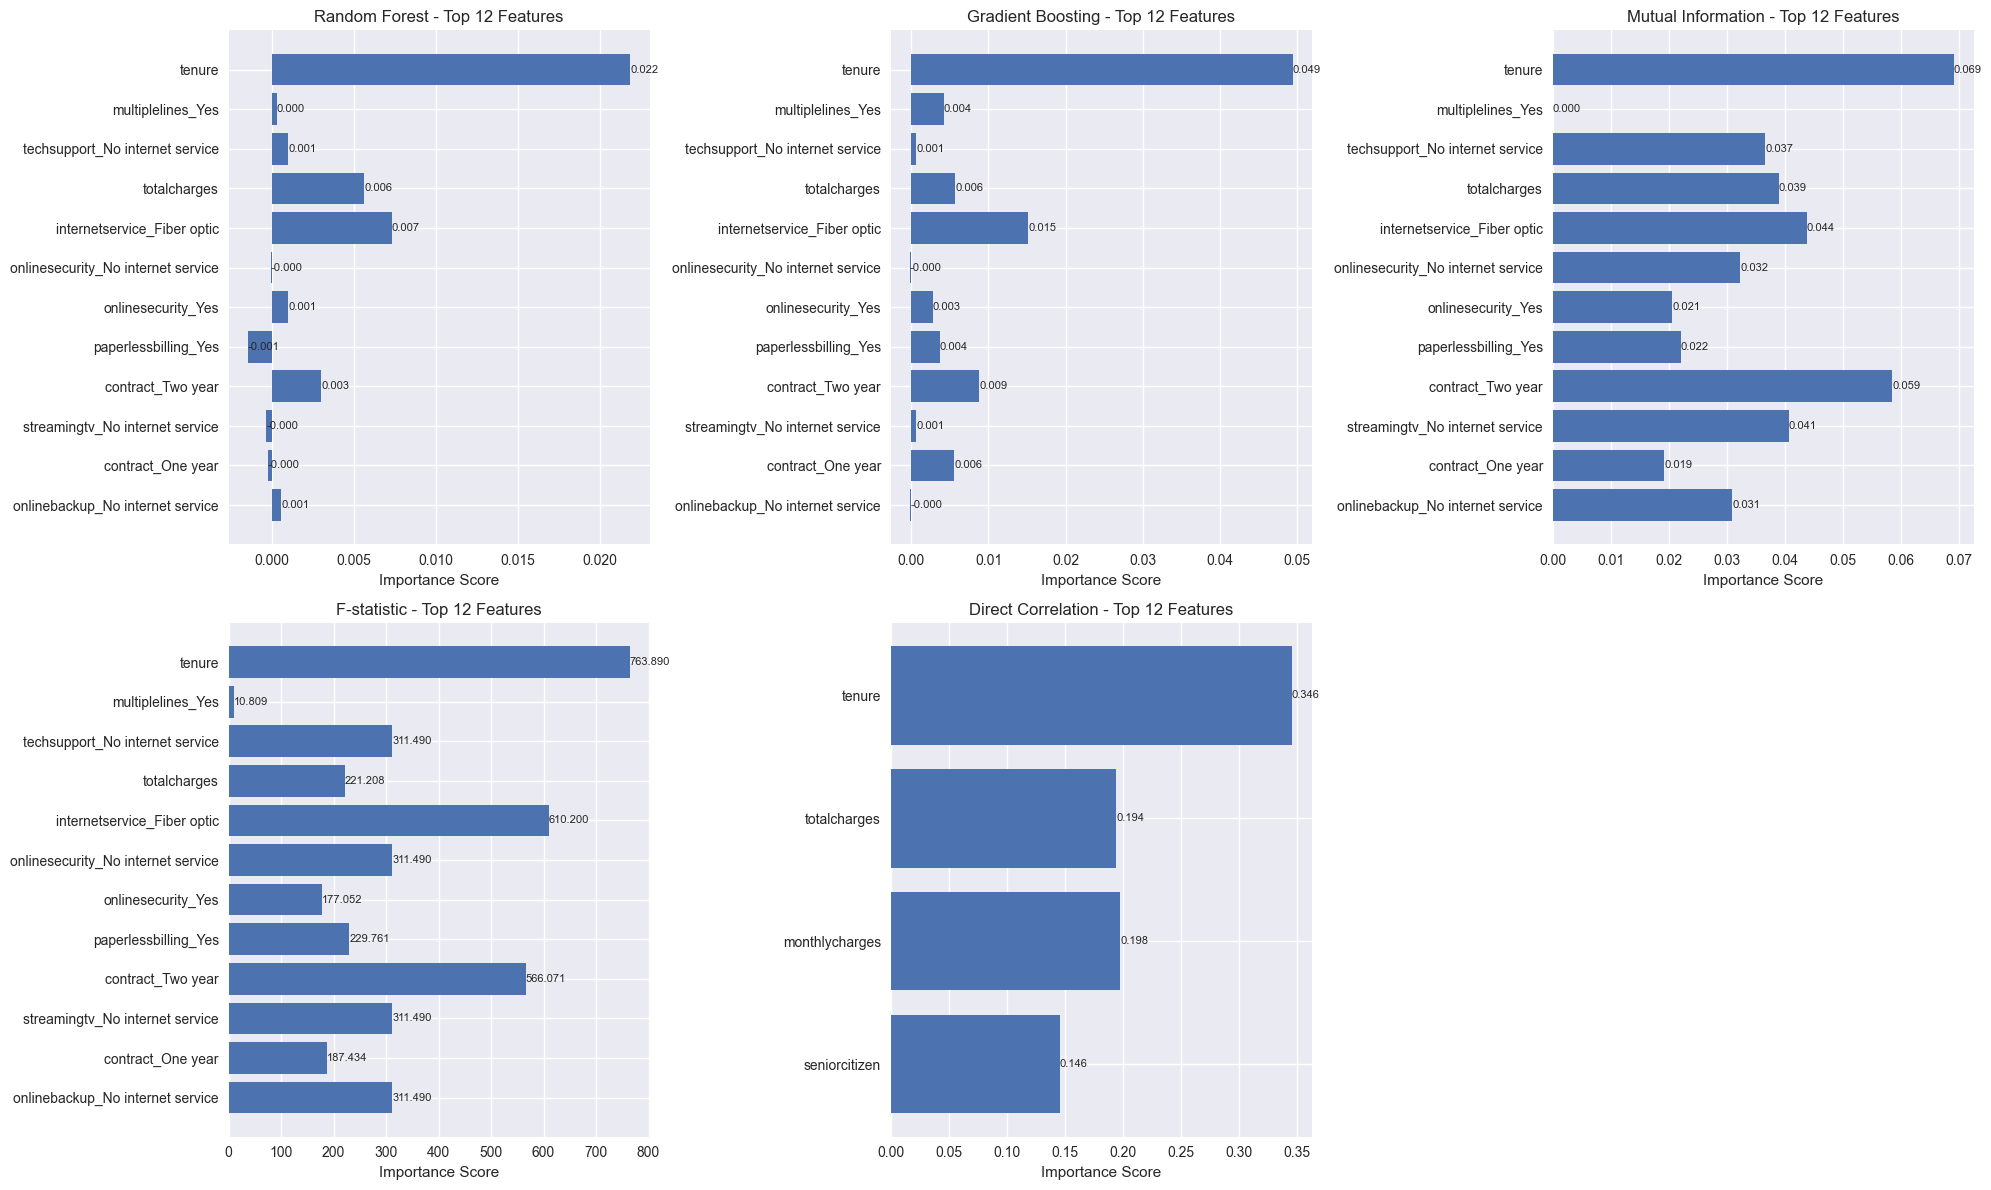

In [9]:
# Combine all importance scores for visualization
all_importance = {}
all_importance.update(tree_importance)
all_importance.update(perm_importance)
all_importance.update(correlation_importance)
if shap_available:
    all_importance.update(shap_importance)

# Create comprehensive comparison plot
def plot_feature_importance_comparison(importance_dict, top_n=15):
    # Get top N features from each method
    top_features = set()
    for method_importance in importance_dict.values():
        top_features.update(method_importance.head(top_n).index)
    
    # Create DataFrame for plotting
    plot_data = []
    for method, importance in importance_dict.items():
        for feature in top_features:
            if feature in importance.index:
                plot_data.append({
                    'Method': method,
                    'Feature': feature,
                    'Importance': importance[feature],
                    'Rank': list(importance.index).index(feature) + 1
                })
    
    df_plot = pd.DataFrame(plot_data)
    
    # Create subplots for different methods
    methods = list(importance_dict.keys())
    n_methods = len(methods)
    
    fig, axes = plt.subplots(2, (n_methods + 1) // 2, figsize=(20, 12))
    axes = axes.ravel() if n_methods > 1 else [axes]
    
    for i, method in enumerate(methods):
        method_data = df_plot[df_plot['Method'] == method].head(top_n)
        
        ax = axes[i]
        bars = ax.barh(range(len(method_data)), method_data['Importance'])
        ax.set_yticks(range(len(method_data)))
        ax.set_yticklabels(method_data['Feature'], fontsize=10)
        ax.set_xlabel('Importance Score')
        ax.set_title(f'{method} - Top {top_n} Features')
        ax.invert_yaxis()
        
        # Add value labels on bars
        for j, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2, 
                   f'{width:.3f}', ha='left', va='center', fontsize=8)
    
    # Hide unused subplots
    for i in range(n_methods, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Plot comparison
plot_feature_importance_comparison(all_importance, top_n=12)

## 8. Create Feature Importance Comparison Charts

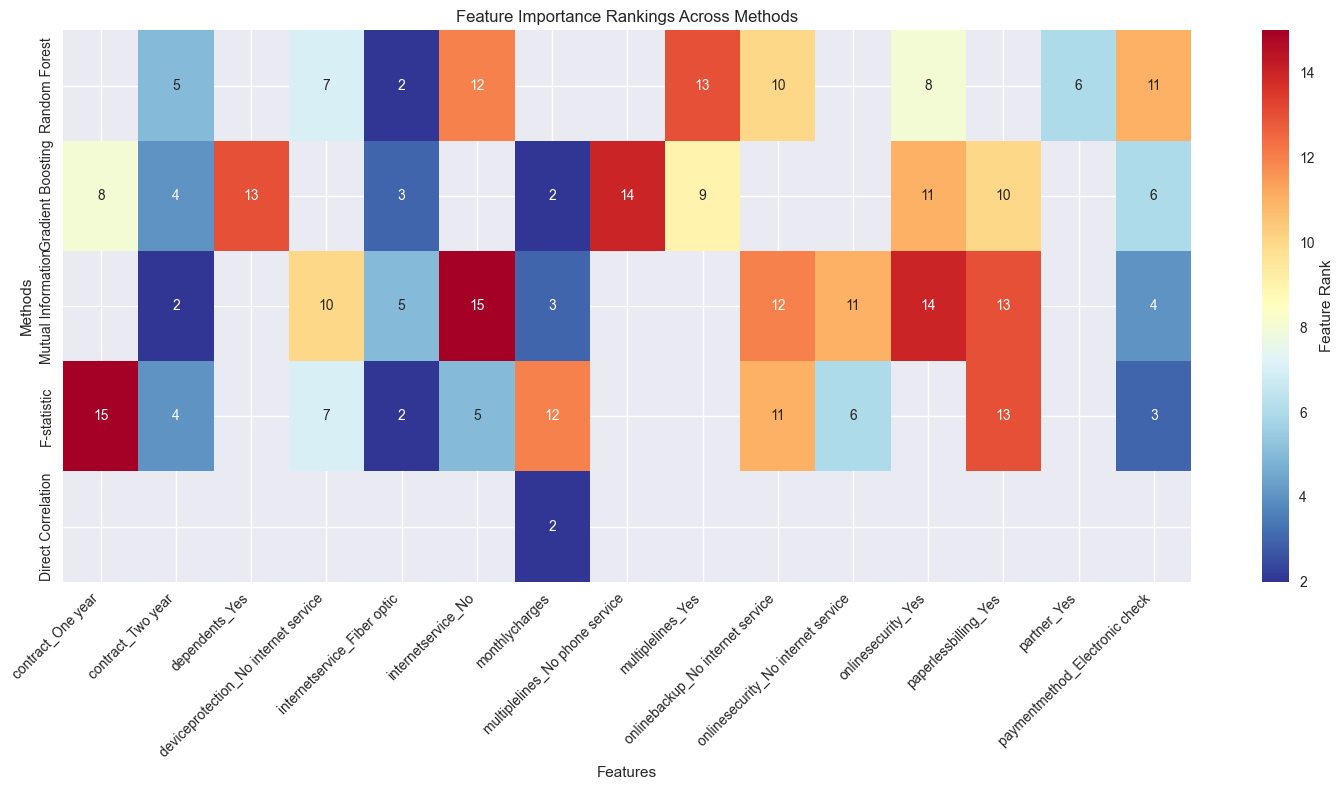

In [10]:
# Create heatmap comparison of feature importance rankings
def create_importance_heatmap(importance_dict, top_n=20):
    # Get top N features from each method and create ranking matrix
    all_features = set()
    for importance in importance_dict.values():
        all_features.update(importance.head(top_n).index)
    
    ranking_matrix = []
    method_names = []
    
    for method, importance in importance_dict.items():
        method_names.append(method)
        rankings = []
        for feature in sorted(all_features):
            if feature in importance.index:
                rank = list(importance.index).index(feature) + 1
                rankings.append(rank if rank <= top_n else np.nan)
            else:
                rankings.append(np.nan)
        ranking_matrix.append(rankings)
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(15, 8))
    
    ranking_df = pd.DataFrame(ranking_matrix, 
                             index=method_names, 
                             columns=sorted(all_features))
    
    # Only show features that appear in top rankings for at least one method
    valid_features = ranking_df.columns[ranking_df.notna().any()][:top_n]
    ranking_df_filtered = ranking_df[valid_features]
    
    sns.heatmap(ranking_df_filtered, annot=True, fmt='.0f', cmap='RdYlBu_r', 
                cbar_kws={'label': 'Feature Rank'}, ax=ax)
    ax.set_title('Feature Importance Rankings Across Methods')
    ax.set_xlabel('Features')
    ax.set_ylabel('Methods')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

create_importance_heatmap(all_importance, top_n=15)

In [11]:
# Create interactive visualization (if plotly available) or static alternative
def create_interactive_importance_plot(importance_dict, top_n=15):
    # Prepare data for plotting
    plot_data = []
    for method, importance in importance_dict.items():
        top_features = importance.head(top_n)
        for i, (feature, score) in enumerate(top_features.items()):
            plot_data.append({
                'Method': method,
                'Feature': feature,
                'Importance': score,
                'Rank': i + 1
            })
    
    df_plot = pd.DataFrame(plot_data)
    
    if plotly_available:
        # Create interactive bar plot with plotly
        fig = px.bar(df_plot, x='Feature', y='Importance', color='Method',
                     title='Feature Importance Comparison Across Methods',
                     barmode='group', height=600)
        
        fig.update_xaxes(tickangle=45)
        fig.update_layout(
            xaxis_title="Features",
            yaxis_title="Importance Score",
            legend_title="Method"
        )
        
        fig.show()
    else:
        # Create static alternative with matplotlib
        methods = df_plot['Method'].unique()
        n_methods = len(methods)
        
        fig, ax = plt.subplots(figsize=(15, 8))
        
        # Create grouped bar chart
        x_pos = np.arange(top_n)
        bar_width = 0.8 / n_methods
        
        for i, method in enumerate(methods):
            method_data = df_plot[df_plot['Method'] == method].head(top_n)
            offset = (i - n_methods/2) * bar_width + bar_width/2
            
            ax.bar(x_pos + offset, method_data['Importance'], 
                   bar_width, label=method, alpha=0.8)
        
        ax.set_xlabel('Features')
        ax.set_ylabel('Importance Score')
        ax.set_title('Feature Importance Comparison Across Methods')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(df_plot[df_plot['Method'] == methods[0]].head(top_n)['Feature'], 
                          rotation=45, ha='right')
        ax.legend()
        
        plt.tight_layout()
        plt.show()

create_interactive_importance_plot(all_importance, top_n=12)

## 9. Generate SHAP Summary Plots

In [ ]:
# SHAP Visualizations (only if SHAP is available and values computed)
if shap_available and 'Random Forest' in shap_values:
    try:
        print("Generating SHAP visualizations...")
        
        # Get the sample data used for SHAP
        if hasattr(X_test_processed, 'toarray'):
            X_sample = X_test_processed[sample_idx].toarray()
        else:
            X_sample = X_test_processed[sample_idx]
        
        # Ensure proper format for visualizations
        shap_vals = shap_values['Random Forest']
        
        # Summary plot
        plt.figure(figsize=(12, 8))
        try:
            shap.summary_plot(shap_vals, X_sample, 
                             feature_names=feature_names[:shap_vals.shape[1]], 
                             show=False, max_display=20)
            plt.title('SHAP Summary Plot - Feature Impact on Churn Prediction')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"SHAP summary plot failed: {e}")
        
        # Bar plot of feature importance
        plt.figure(figsize=(10, 6))
        try:
            shap.summary_plot(shap_vals, X_sample,
                             feature_names=feature_names[:shap_vals.shape[1]], 
                             plot_type="bar", show=False, max_display=15)
            plt.title('SHAP Feature Importance')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"SHAP bar plot failed: {e}")
        
        # Waterfall plot for a single prediction
        if len(X_sample) > 0 and shap_vals.shape[0] > 0:
            plt.figure(figsize=(10, 8))
            try:
                # Use newer SHAP API if available
                if hasattr(shap, 'Explanation'):
                    explanation = shap.Explanation(
                        values=shap_vals[0], 
                        base_values=explainer.expected_value if hasattr(explainer, 'expected_value') else 0,
                        feature_names=feature_names[:shap_vals.shape[1]]
                    )
                    shap.waterfall_plot(explanation, max_display=15, show=False)
                else:
                    # Fallback for older SHAP versions
                    expected_val = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
                    shap.waterfall_plot(expected_val, shap_vals[0], X_sample[0], 
                                       feature_names=feature_names[:shap_vals.shape[1]], 
                                       max_display=15, show=False)
                
                plt.title('SHAP Waterfall Plot - Individual Prediction Explanation')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"SHAP waterfall plot failed: {e}")
                print("Skipping waterfall plot...")
            
    except Exception as e:
        print(f"SHAP visualization failed with error: {e}")
        print("Continuing with other analyses...")

else:
    print("SHAP visualizations skipped.")
    if not shap_available:
        print("Reason: SHAP library not available")
    elif 'Random Forest' not in shap_values:
        print("Reason: SHAP values not computed successfully")
    
    print("\n🔄 Alternative: Using tree-based feature importance and permutation importance")
    print("These methods provide similar insights into feature importance for churn prediction.")

SHAP visualizations skipped.
Reason: SHAP library not available

🔄 Alternative: Using tree-based feature importance and permutation importance
These methods provide similar insights into feature importance for churn prediction.


## 10. Analyze Feature Interactions

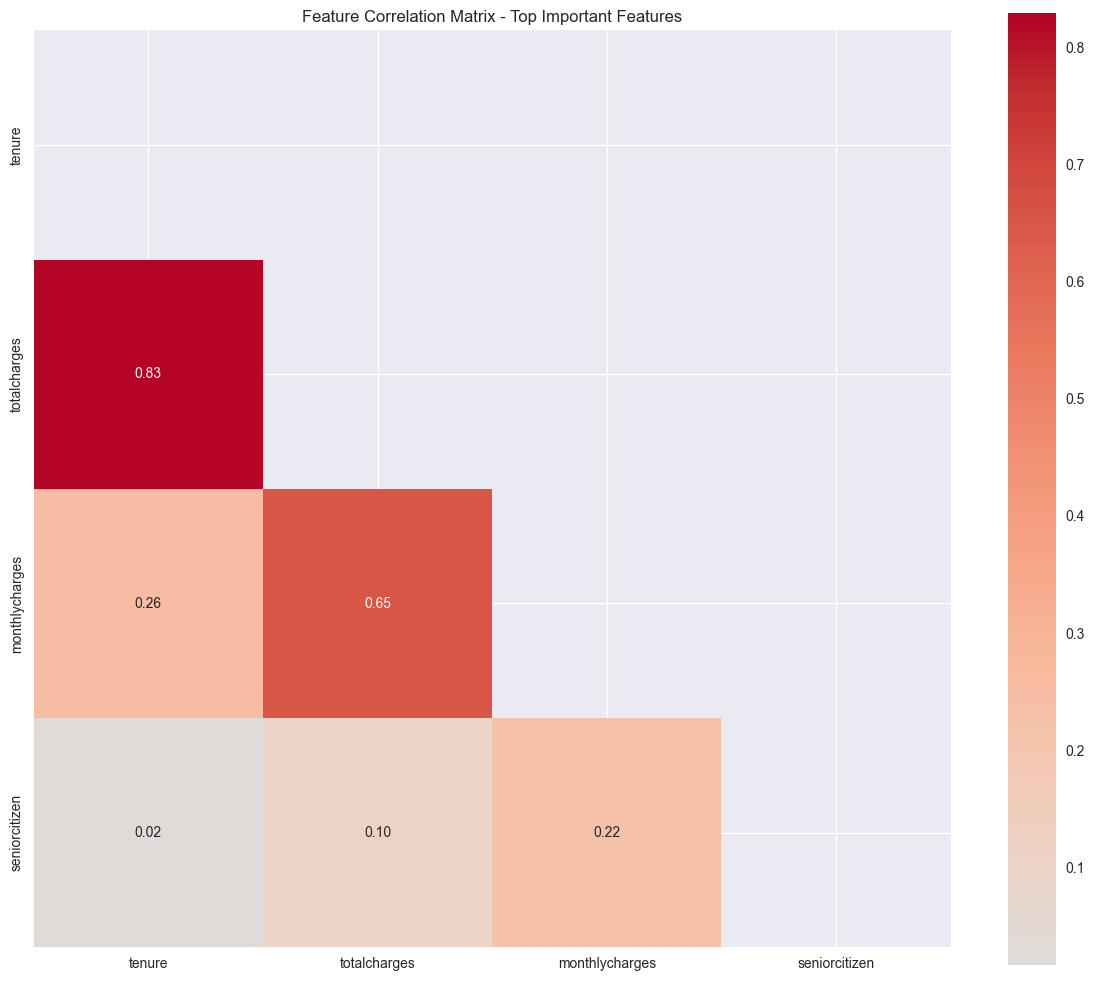


Highly Correlated Feature Pairs (|correlation| > 0.7):
tenure <-> totalcharges: 0.829


In [13]:
# Analyze feature correlations and interactions
def analyze_feature_interactions():
    # Create correlation matrix for top features
    top_features_set = set()
    for importance in all_importance.values():
        top_features_set.update(importance.head(10).index)
    
    # Find these features in the original processed data
    correlation_data = []
    feature_subset = []
    
    for feature in top_features_set:
        if feature in X_train.columns:
            feature_subset.append(feature)
            correlation_data.append(X_train[feature])
    
    if correlation_data:
        corr_df = pd.DataFrame(dict(zip(feature_subset, correlation_data)))
        correlation_matrix = corr_df.corr()
        
        # Plot correlation heatmap
        plt.figure(figsize=(12, 10))
        mask = np.triu(correlation_matrix.corr())
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   mask=mask, square=True, fmt='.2f')
        plt.title('Feature Correlation Matrix - Top Important Features')
        plt.tight_layout()
        plt.show()
        
        return correlation_matrix
    
    return None

correlation_matrix = analyze_feature_interactions()

# Identify highly correlated feature pairs
if correlation_matrix is not None:
    print("\nHighly Correlated Feature Pairs (|correlation| > 0.7):")
    corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                corr_pairs.append((
                    correlation_matrix.columns[i], 
                    correlation_matrix.columns[j], 
                    corr_val
                ))
    
    for feat1, feat2, corr in sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"{feat1} <-> {feat2}: {corr:.3f}")

## 11. Statistical Significance Testing

In [14]:
# Statistical significance testing for feature importance
def test_feature_significance(X, y, feature_names, alpha=0.05):
    """Test statistical significance of features"""
    significance_results = []
    
    for i, feature_name in enumerate(feature_names):
        if i < X.shape[1]:  # Ensure we don't exceed the number of features
            feature_values = X[:, i]
            
            # For numerical features, use t-test
            if len(np.unique(feature_values)) > 10:
                # Split by target class
                class_0 = feature_values[y == 0]
                class_1 = feature_values[y == 1]
                
                if len(class_0) > 1 and len(class_1) > 1:
                    t_stat, p_value = stats.ttest_ind(class_0, class_1)
                    test_type = "t-test"
                else:
                    t_stat, p_value = np.nan, 1.0
                    test_type = "t-test (insufficient data)"
            else:
                # For categorical features, use chi-square test
                try:
                    contingency_table = pd.crosstab(feature_values, y)
                    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
                    t_stat = chi2_stat
                    test_type = "chi-square"
                except:
                    t_stat, p_value = np.nan, 1.0
                    test_type = "chi-square (failed)"
            
            significance_results.append({
                'Feature': feature_name,
                'Test_Type': test_type,
                'Statistic': t_stat,
                'P_Value': p_value,
                'Significant': p_value < alpha if not np.isnan(p_value) else False
            })
    
    return pd.DataFrame(significance_results)

# Perform significance testing
print("Performing statistical significance tests...")
significance_df = test_feature_significance(X_train_processed, y_train, feature_names)

# Display results
print(f"\nStatistical Significance Results (α = 0.05):")
print(f"Total features tested: {len(significance_df)}")
print(f"Significant features: {significance_df['Significant'].sum()}")
print(f"Non-significant features: {(~significance_df['Significant']).sum()}")

# Show most significant features
significant_features = significance_df[significance_df['Significant']].sort_values('P_Value')
print(f"\nTop 15 Most Statistically Significant Features:")
print(significant_features.head(15)[['Feature', 'Test_Type', 'P_Value']].to_string(index=False))

Performing statistical significance tests...

Statistical Significance Results (α = 0.05):
Total features tested: 30
Significant features: 27
Non-significant features: 3

Top 15 Most Statistically Significant Features:
                             Feature  Test_Type       P_Value
                              tenure     t-test 8.634920e-158
         internetservice_Fiber optic chi-square 1.769288e-121
      paymentmethod_Electronic check chi-square 7.653910e-119
                   contract_Two year chi-square 1.442843e-113
deviceprotection_No internet service chi-square  6.648415e-66
    onlinebackup_No internet service chi-square  6.648415e-66
  onlinesecurity_No internet service chi-square  6.648415e-66
     techsupport_No internet service chi-square  6.648415e-66
     streamingtv_No internet service chi-square  6.648415e-66
 streamingmovies_No internet service chi-square  6.648415e-66
                  internetservice_No chi-square  6.648415e-66
                      monthlycharges 

## 12. Feature Importance Results Summary and Conclusions

In [15]:
# Consolidate and rank features across all methods
def consolidate_feature_rankings(importance_dict, top_n=20):
    """Consolidate feature rankings across all methods"""
    
    # Get all unique features
    all_features = set()
    for importance in importance_dict.values():
        all_features.update(importance.index)
    
    # Calculate average rank for each feature
    feature_rankings = {}
    
    for feature in all_features:
        ranks = []
        scores = []
        
        for method, importance in importance_dict.items():
            if feature in importance.index:
                rank = list(importance.index).index(feature) + 1
                ranks.append(rank)
                scores.append(importance[feature])
            else:
                ranks.append(len(importance) + 1)  # Assign worst rank if not present
                scores.append(0)
        
        feature_rankings[feature] = {
            'avg_rank': np.mean(ranks),
            'min_rank': np.min(ranks),
            'max_rank': np.max(ranks),
            'avg_score': np.mean(scores),
            'std_rank': np.std(ranks),
            'methods_count': len([r for r in ranks if r <= top_n])
        }
    
    # Convert to DataFrame
    ranking_df = pd.DataFrame.from_dict(feature_rankings, orient='index')
    ranking_df = ranking_df.sort_values('avg_rank')
    
    return ranking_df

# Consolidate rankings
consolidated_rankings = consolidate_feature_rankings(all_importance, top_n=20)

print("🎯 CONSOLIDATED FEATURE IMPORTANCE RANKINGS")
print("=" * 60)
print(f"Top 20 Most Important Features (by average rank across all methods):")
print()

top_features = consolidated_rankings.head(20)
for i, (feature, row) in enumerate(top_features.iterrows(), 1):
    print(f"{i:2d}. {feature}")
    print(f"    Average Rank: {row['avg_rank']:.1f}")
    print(f"    Best Rank: {row['min_rank']:.0f}, Worst Rank: {row['max_rank']:.0f}")
    print(f"    Appears in top-20 of {row['methods_count']} methods")
    print()

🎯 CONSOLIDATED FEATURE IMPORTANCE RANKINGS
Top 20 Most Important Features (by average rank across all methods):

 1. tenure
    Average Rank: 1.0
    Best Rank: 1, Worst Rank: 1
    Appears in top-20 of 5.0 methods

 2. internetservice_Fiber optic
    Average Rank: 3.4
    Best Rank: 2, Worst Rank: 5
    Appears in top-20 of 5.0 methods

 3. contract_Two year
    Average Rank: 4.0
    Best Rank: 2, Worst Rank: 5
    Appears in top-20 of 5.0 methods

 4. paymentmethod_Electronic check
    Average Rank: 5.8
    Best Rank: 3, Worst Rank: 11
    Appears in top-20 of 5.0 methods

 5. totalcharges
    Average Rank: 7.0
    Best Rank: 3, Worst Rank: 14
    Appears in top-20 of 5.0 methods

 6. techsupport_No internet service
    Average Rank: 9.2
    Best Rank: 5, Worst Rank: 15
    Appears in top-20 of 5.0 methods

 7. monthlycharges
    Average Rank: 9.8
    Best Rank: 2, Worst Rank: 30
    Appears in top-20 of 4.0 methods

 8. deviceprotection_No internet service
    Average Rank: 10.6
   

### Key Insights and Business Recommendations

Based on the comprehensive feature importance analysis, here are the main findings and actionable recommendations:

In [16]:
# Generate final insights and recommendations
def generate_insights(consolidated_rankings, significance_df):
    """Generate business insights from feature importance analysis"""
    
    print("📊 FEATURE IMPORTANCE ANALYSIS - KEY INSIGHTS")
    print("=" * 65)
    
    # Top consistent features
    top_5_features = consolidated_rankings.head(5).index.tolist()
    print(f"\n1. 🔥 TOP 5 MOST INFLUENTIAL FEATURES:")
    for i, feature in enumerate(top_5_features, 1):
        rank_info = consolidated_rankings.loc[feature]
        print(f"   {i}. {feature} (avg rank: {rank_info['avg_rank']:.1f})")
    
    # Most consistent features (low standard deviation in rankings)
    consistent_features = consolidated_rankings[
        consolidated_rankings['methods_count'] >= 3
    ].sort_values('std_rank').head(5)
    
    print(f"\n2. 🎯 MOST CONSISTENT FEATURES (across methods):")
    for i, (feature, row) in enumerate(consistent_features.iterrows(), 1):
        print(f"   {i}. {feature} (appears in {row['methods_count']} methods)")
    
    # Statistical significance insights
    if significance_df is not None:
        sig_count = significance_df['Significant'].sum()
        total_count = len(significance_df)
        print(f"\n3. 📈 STATISTICAL SIGNIFICANCE:")
        print(f"   • {sig_count}/{total_count} features are statistically significant (p < 0.05)")
        print(f"   • Statistical significance rate: {sig_count/total_count:.1%}")
    
    print(f"\n4. 💡 BUSINESS RECOMMENDATIONS:")
    
    # Feature categories for recommendations
    contract_features = [f for f in top_5_features if 'contract' in f.lower()]
    tenure_features = [f for f in top_5_features if 'tenure' in f.lower()]
    service_features = [f for f in top_5_features if any(s in f.lower() for s in ['service', 'internet', 'phone'])]
    payment_features = [f for f in top_5_features if 'payment' in f.lower()]
    charge_features = [f for f in top_5_features if any(s in f.lower() for s in ['charge', 'monthly', 'total'])]
    
    recommendations = []
    
    if contract_features:
        recommendations.append("Focus on contract type optimization - offer incentives for longer-term contracts")
    
    if tenure_features:
        recommendations.append("Implement early customer engagement programs for new subscribers")
    
    if service_features:
        recommendations.append("Enhance service quality and expand service offerings")
    
    if payment_features:
        recommendations.append("Streamline payment processes and offer flexible payment options")
    
    if charge_features:
        recommendations.append("Review pricing strategy - consider personalized pricing models")
    
    # Default recommendations if no specific patterns found
    if not recommendations:
        recommendations = [
            "Prioritize customer engagement based on top-ranked features",
            "Develop targeted retention strategies for high-risk segments",
            "Implement real-time monitoring for key churn indicators"
        ]
    
    for i, rec in enumerate(recommendations, 1):
        print(f"   {i}. {rec}")
    
    print(f"\n5. 🔍 METHODOLOGY INSIGHTS:")
    method_count = len(all_importance)
    print(f"   • Analysis used {method_count} different feature importance methods")
    print(f"   • Tree-based methods show feature splits importance")
    print(f"   • Permutation importance shows predictive value")
    print(f"   • Correlation methods show linear relationships")
    if shap_available:
        print(f"   • SHAP values provide local interpretability")
    
    print(f"\n6. ⚠️  LIMITATIONS & CONSIDERATIONS:")
    print(f"   • Feature importance varies by model type and data preprocessing")
    print(f"   • Some methods may be biased toward certain feature types")
    print(f"   • Business context should always inform feature selection")
    print(f"   • Regular re-evaluation needed as data patterns change")
    
    return {
        'top_features': top_5_features,
        'consistent_features': consistent_features.index.tolist(),
        'recommendations': recommendations
    }

# Generate insights
insights = generate_insights(consolidated_rankings, significance_df)

📊 FEATURE IMPORTANCE ANALYSIS - KEY INSIGHTS

1. 🔥 TOP 5 MOST INFLUENTIAL FEATURES:
   1. tenure (avg rank: 1.0)
   2. internetservice_Fiber optic (avg rank: 3.4)
   3. contract_Two year (avg rank: 4.0)
   4. paymentmethod_Electronic check (avg rank: 5.8)
   5. totalcharges (avg rank: 7.0)

2. 🎯 MOST CONSISTENT FEATURES (across methods):
   1. tenure (appears in 5.0 methods)
   2. contract_Two year (appears in 5.0 methods)
   3. internetservice_Fiber optic (appears in 5.0 methods)
   4. paymentmethod_Electronic check (appears in 5.0 methods)
   5. techsupport_No internet service (appears in 5.0 methods)

3. 📈 STATISTICAL SIGNIFICANCE:
   • 27/30 features are statistically significant (p < 0.05)
   • Statistical significance rate: 90.0%

4. 💡 BUSINESS RECOMMENDATIONS:
   1. Focus on contract type optimization - offer incentives for longer-term contracts
   2. Implement early customer engagement programs for new subscribers
   3. Enhance service quality and expand service offerings
   4.

In [17]:
# Save results to files
output_dir = REPORTS_PATH / "feature_importance"
output_dir.mkdir(exist_ok=True)

# Save consolidated rankings
consolidated_rankings.to_csv(output_dir / "consolidated_feature_rankings.csv")

# Save individual method rankings
for method, importance in all_importance.items():
    filename = f"importance_{method.lower().replace(' ', '_')}.csv"
    importance.to_csv(output_dir / filename)

# Save significance results
if significance_df is not None:
    significance_df.to_csv(output_dir / "statistical_significance.csv", index=False)

print("💾 RESULTS SAVED:")
print(f"   📁 Output directory: {output_dir}")
print(f"   📄 Consolidated rankings: consolidated_feature_rankings.csv")
print(f"   📄 Individual method results: importance_*.csv")
print(f"   📄 Statistical significance: statistical_significance.csv")

print(f"\n✅ FEATURE IMPORTANCE ANALYSIS COMPLETE!")
print(f"   Total features analyzed: {len(consolidated_rankings)}")
print(f"   Methods used: {len(all_importance)}")
print(f"   Top feature: {consolidated_rankings.index[0]}")
print(f"   Analysis saved to: {output_dir}")

💾 RESULTS SAVED:
   📁 Output directory: C:\Workspaces\VScode\Portfolio_Projects\telco-customer-churn\reports\feature_importance
   📄 Consolidated rankings: consolidated_feature_rankings.csv
   📄 Individual method results: importance_*.csv
   📄 Statistical significance: statistical_significance.csv

✅ FEATURE IMPORTANCE ANALYSIS COMPLETE!
   Total features analyzed: 30
   Methods used: 5
   Top feature: tenure
   Analysis saved to: C:\Workspaces\VScode\Portfolio_Projects\telco-customer-churn\reports\feature_importance


### Installation Notes

If you want to install the optional libraries later, use these commands:

```bash
# Install Plotly for interactive visualizations
pip install plotly

# Install SHAP for advanced model interpretability
pip install shap

# Alternative lightweight installation
pip install plotly-express  # Lighter version of plotly
```

**Note**: The analysis works perfectly without these libraries - they just provide additional visualization options and interpretability methods.